# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

if not os.path.exists('data'):
    new_directory_path = "..\\..\\"
    os.chdir(new_directory_path)
from src.data.parsers import OurDataset, CocoFreeView
from src.preprocess.simulation import gen_gaze, downsample
from src.preprocess.noise import (add_random_center_correlated_radial_noise,
                                 discretization_noise)     
from src.data.datasets import FreeViewInMemory    
from src.eval.vis_scanpath import draw_scanpath_mpl
from src.eval.eval_utils import plot_amplitude_dist, plot_angle_distribution, plot_autocorrelation, plot_consecutive_angles, plot_vector_dist, calculate_relative_vectors                        

## Variacion de la distancia del sujeto con la pantalla

La variación de las distancias entre los landmarks depende de:
* El ruido del detector
* La rotación en torno a los ejes ortogonales al eje de la camara
* La distancia del objeto a la camara

The rotation can be cleaned dividing by the cosine of the yaw

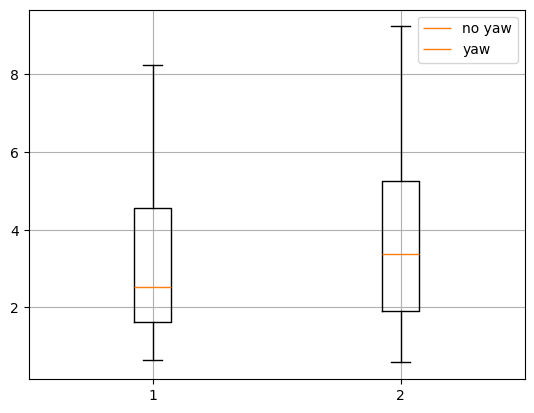

In [2]:
data = pd.read_csv('data\\Ours\\result_total_data_prosegur.csv')
    
data_t = data.groupby(['User'])
landmark_list = []
for key, value in data_t:
    landmarks = value[['XEyeLeft','YEyeLeft','XEyeRight','YEyeRight', 'Yaw']]
    if len(landmarks) > 10:
        landmark_list.append(landmarks.to_numpy())
        
v_list = []
vc_list = []
d_list = []
c_list = []

for lm in landmark_list:
    # lm = lm[np.abs(lm[:,4]) < 20]
    d = (((lm[:,0] - lm[:,2])**2 + (lm[:,1] - lm[:,3])**2)**(1/2))
    d_list.append(d)
    c = d/np.cos(np.radians(np.abs(lm[:,4])))
    c_list.append(c)
    v_list.append(d.std())
    vc_list.append(c.std())
    
plt.boxplot([v_list, vc_list], label = ['no yaw', 'yaw'])
plt.grid()
plt.legend()
pass

# Simulation Test

In [3]:
def summary(gaze):
    print('traj count: ', len(gaze))
    sample_per_traj = np.asanyarray([gaze_sample.shape[1] for gaze_sample in gaze])
    print('MIN sample per traj: ', sample_per_traj.min())
    print('MAX sample per traj: ', sample_per_traj.max())
    counts, edge_bin = np.histogram(sample_per_traj)
    bin_center = (edge_bin[1:] + edge_bin[:-1]) / 2
    rev_counts = counts[::-1]
    rev_distr = np.cumsum(rev_counts)
    distr = rev_distr[::-1]
    distr = distr/sample_per_traj.shape[0]
    
    # Plot the CDF
    plt.figure() # Create a new figure
    plt.plot(bin_center, distr)
    plt.title('Normalized Sample Count CDF per Trajectory')
    plt.xlabel('Samples per Trajectory')
    plt.ylabel('Cumulative Probability')
    plt.grid('on')
    plt.show() # Display the plot



## Loading Data

traj count:  2000
MIN sample per traj:  4
MAX sample per traj:  36


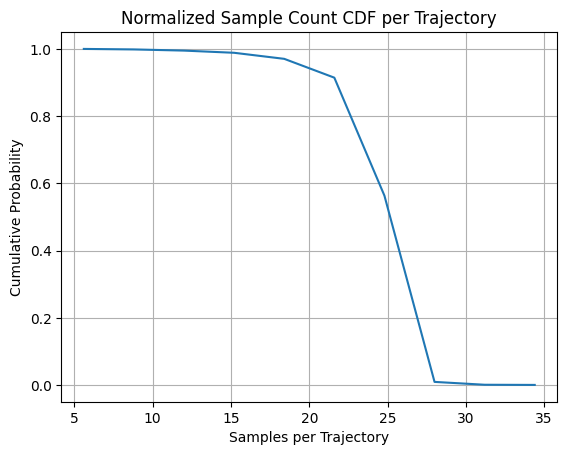

In [4]:
sample_size = 12
data = CocoFreeView()
idx = np.random.randint(0,len(data),2000)
clean_gaze = gen_gaze(data, idx,60)
# RES: (512,360)

down_gaze = downsample(clean_gaze, down_time_step = 200)

cradial_sim_gaze = [item.copy() for item in down_gaze]
cradial_sim_gaze, _ = add_random_center_correlated_radial_noise(cradial_sim_gaze,
                                                                [320//2,512//2],1/16,
                                                                radial_corr = .5,
                                                                radial_avg_norm= 4.13,
                                                                radial_std=5.5,
                                                                center_noise_std=50,
                                                                center_corr=.9,
                                                                center_delta_norm=200,
                                                                center_delta_r=.2)
discretized = [item.copy() for item in cradial_sim_gaze]
discretized = [discretization_noise((320,512), sim) for sim in discretized]

gaze_list = [
             ([item[:,:sample_size] for item in discretized], 'sim_noise', data.ptoa)
             ]
summary(down_gaze)

In [5]:
# datasetv2 = FreeViewInMemory(sample_size= sample_size,log = True)
# idx = np.random.randint(0,len(datasetv2),2000)
# train_data = [datasetv2[i][0] for i in idx]
# gaze_list.append((train_data, 'training', data.ptoa))

traj count:  62
MIN sample per traj:  1
MAX sample per traj:  15


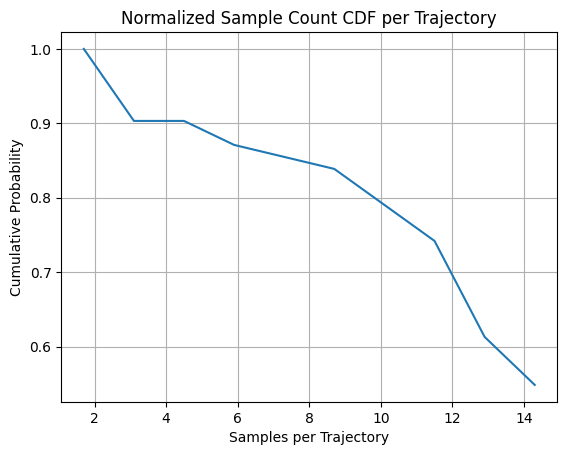

In [6]:
our_data = OurDataset()
# RES: (960,540)
our_gaze = our_data.get_eye_track(idx = range(len(our_data)))
# gaze_list.append((our_gaze, 'our',None))
gaze_list.append(([item[:,:sample_size] for item in our_gaze], 'our data',None))
summary(our_gaze)

# Sim + DS + N vs Ours
* Deepgaze lll Stats 

### Amplitude Distribution

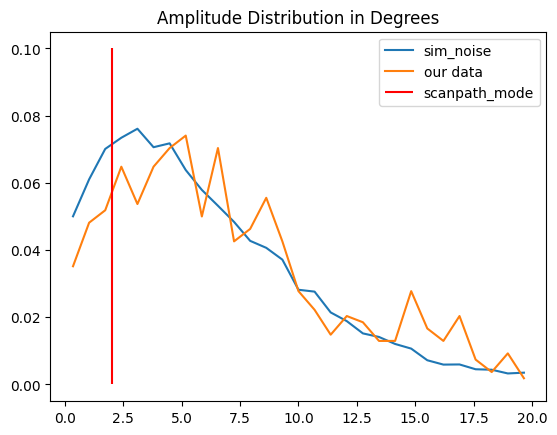

In [7]:
plot_amplitude_dist([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list],
                    [gaze[2] for gaze in gaze_list])
plt.show()

### Orientation Distribution

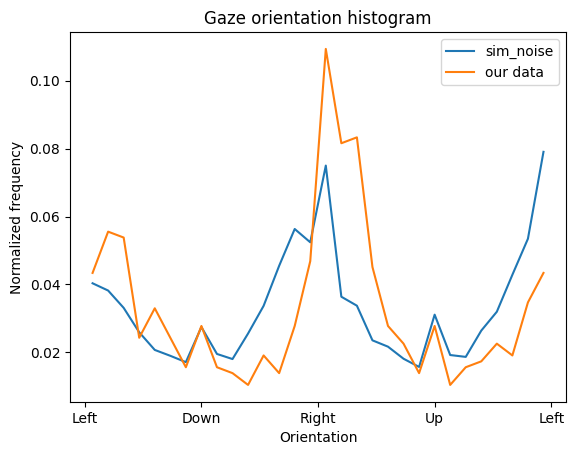

In [8]:
plot_angle_distribution([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list])
plt.show()

### Angles between saccades

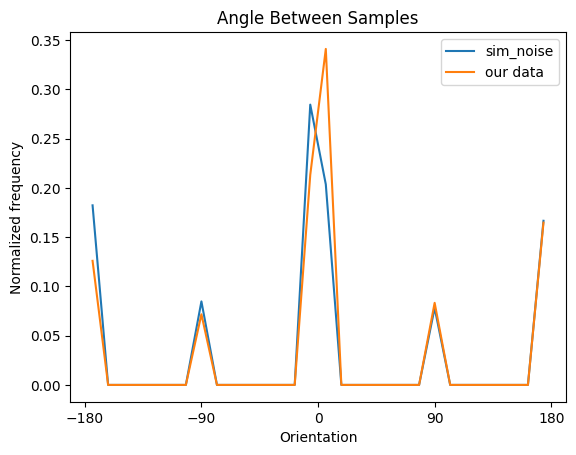

In [9]:
plot_consecutive_angles([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list])
plt.show()

### Autocorrelation

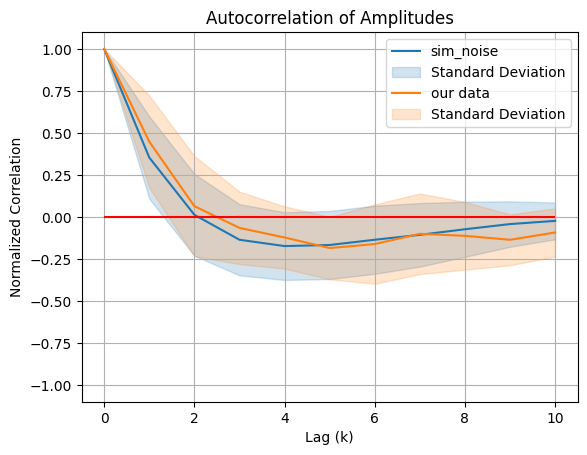

In [10]:
plot_autocorrelation([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list], min_len=sample_size - 1)

### Vector Distribution

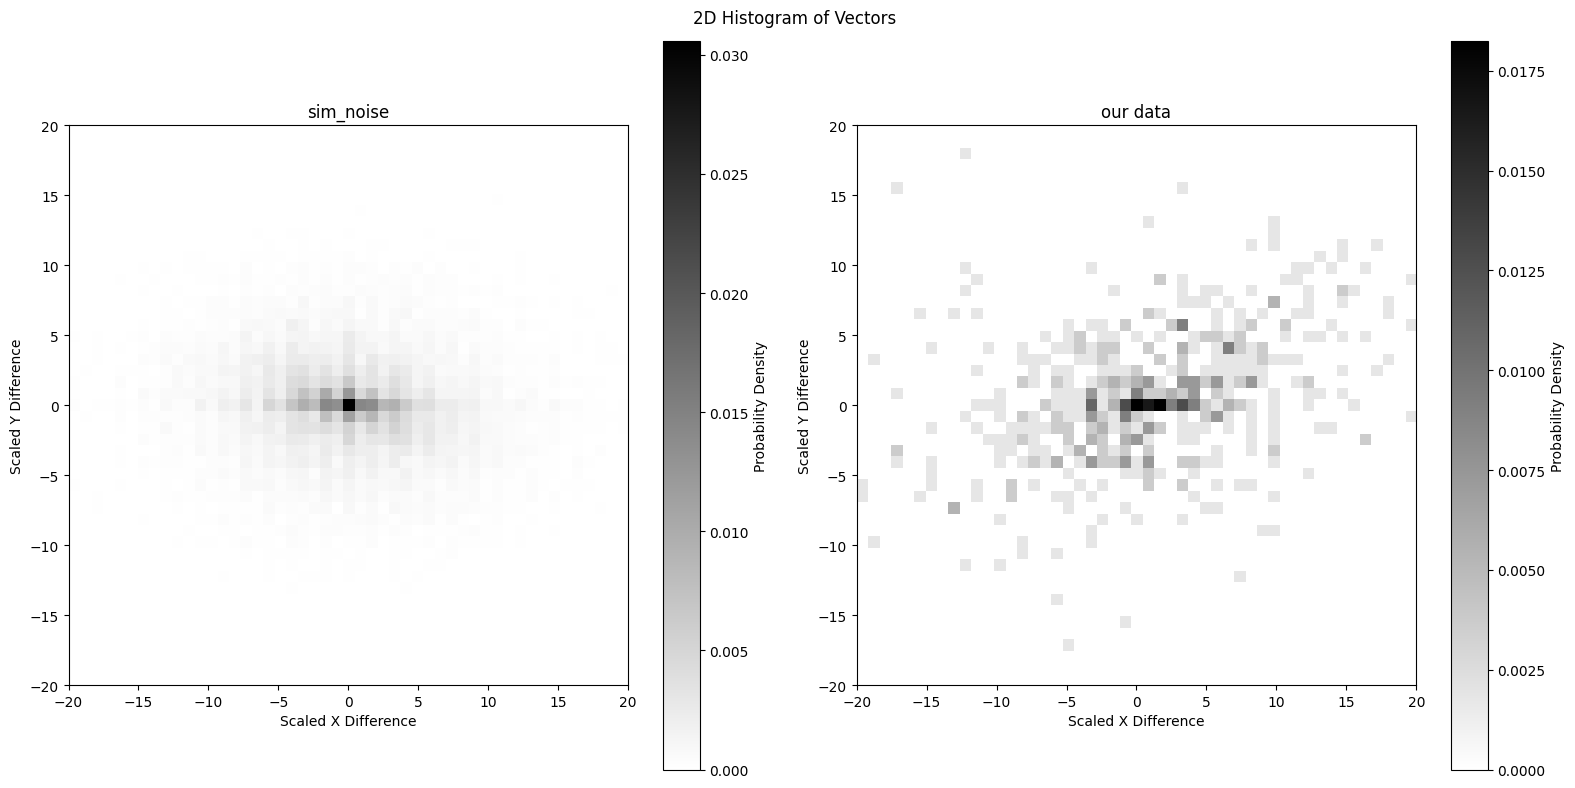

In [11]:
# circ_sim_vec = [np.diff(gaze_sample[:2, :], axis=1) for gaze_sample in circ_sim_gaze]
# elip_sim_vec = [np.diff(gaze_sample[:2, :], axis=1) for gaze_sample in elip_sim_gaze]
# our_vec = [np.diff(gaze_sample[:2, :], axis=1) for gaze_sample in our_gaze]

plot_vector_dist([[np.diff(gaze_sample[:2, :], axis=1) for gaze_sample in gaze[0]] for gaze in gaze_list],
                 [gaze[2] for gaze in gaze_list], 
                 [gaze[1] for gaze in gaze_list],)

### Relative Distribution

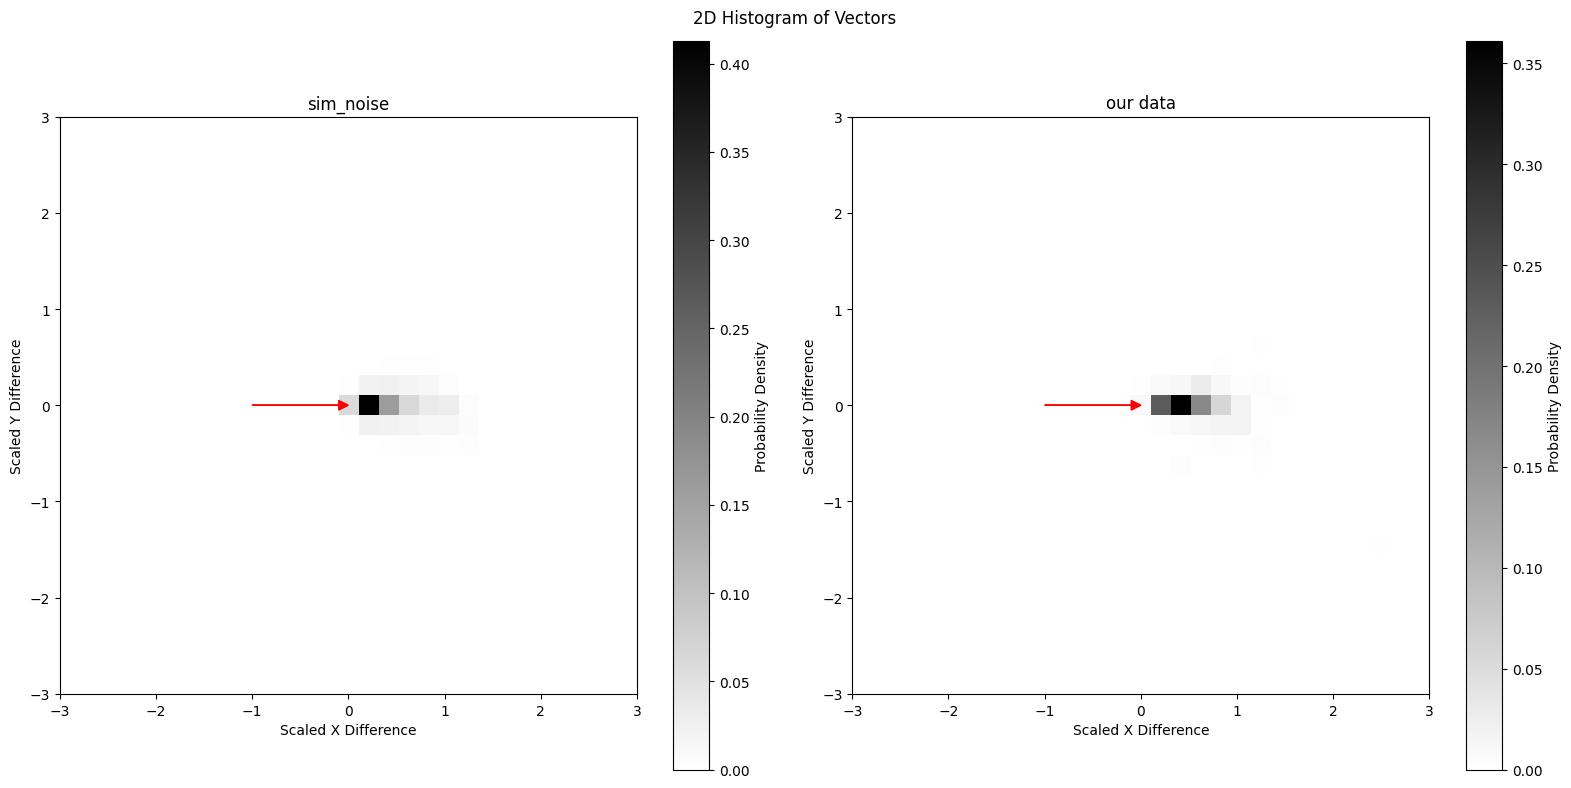

In [12]:
plot_vector_dist([[calculate_relative_vectors(gaze_sample) for gaze_sample in gaze[0]] for gaze in gaze_list],
                    [1 for _ in gaze_list],
                    [gaze[1] for gaze in gaze_list],-3,3,30, arrow= True)

plt.show()

# Visualize Generated Noise vs Samples

In [13]:
from src.data.transforms import AddRandomCenterCorrelatedRadialNoise, ExtractRandomPeriod

transforms = [ExtractRandomPeriod(start_index= 2,
            period_duration= 2600,
            sampling_rate= 60,
            downsample_period= 200,
            random_offset= True),
              AddRandomCenterCorrelatedRadialNoise(initial_center =  [320//2,512//2],
              ptoa =  1/16, 
              radial_corr =  0.5, 
              radial_avg_norm =  4.13, 
              radial_std =  5.5, 
              center_noise_std =  50, 
              center_corr =  0.9, 
              center_delta_norm =  200, 
              center_delta_r =  0.2,
              return_center_path = True)]

data = FreeViewInMemory(transforms = transforms)

In [14]:
item = data[0]

In [15]:
item.keys()

dict_keys(['x', 'y', 'fixation_mask', 'center_path', 'clean_x'])

In [16]:
item['center_path'].shape

(2, 13)

c:\Users\ulloa\OneDrive\Desktop\Practicas\projectes\Dataset\src\eval\vis_scanpath.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[0], y[0], s=marker_size, c=end_color, zorder=5)


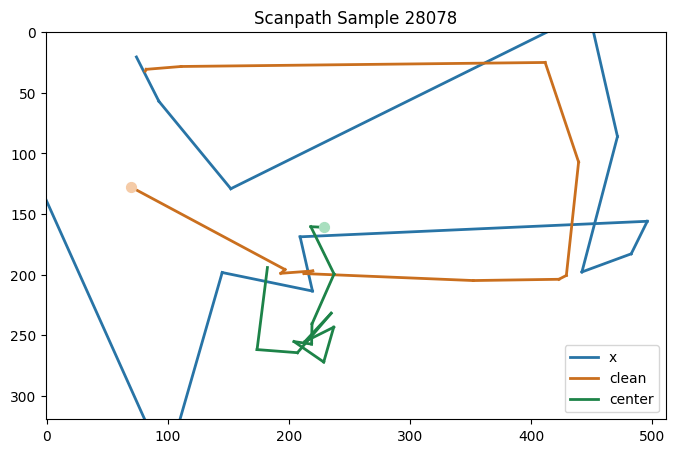

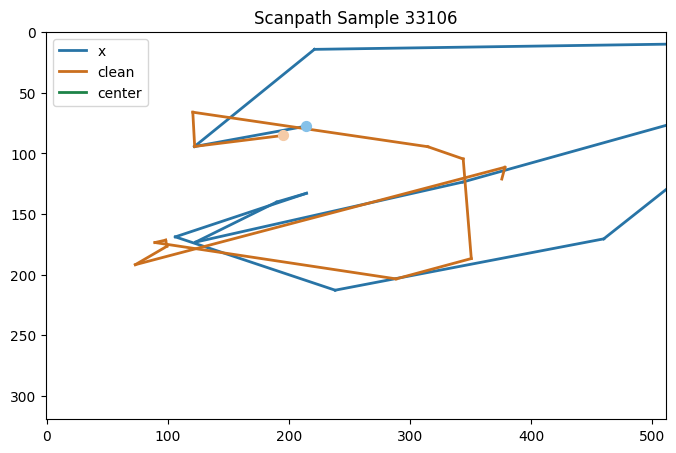

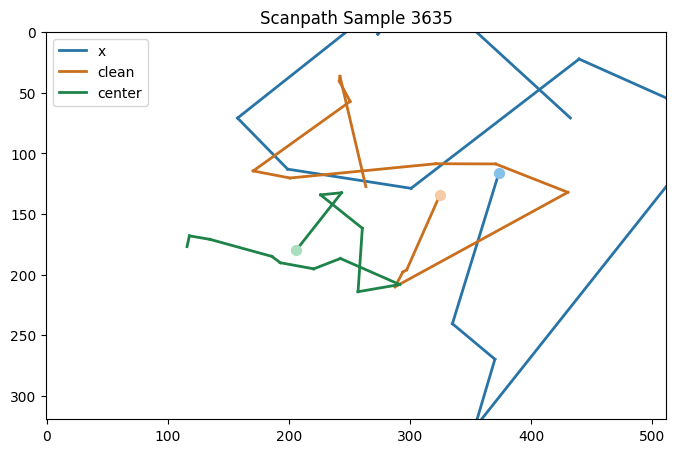

In [17]:
from random import randint

for i in range(3):
    idx = randint(0,len(data) - 1)
    item = data[idx]
    img = np.ones((320,512,3),dtype=np.uint8)*255

    label = ['x', 'clean', 'center']

    traj = [item['x'],
            item['clean_x'], 
            item['center_path']]
    traj_colors = [(40/255, 116/255, 166/255), # blue
                (202/255, 111/255, 30/255), # orange
                (29/255, 131/255, 72/255)] # green

    end_point_colors = [(133/255, 193/255, 233/255),
                        (245/255, 203/255, 167/255),
                        (169/255, 223/255, 191/255)]
    fig, ax = plt.subplots(figsize=(8,8))
    for traj, color, end_color, lbl in zip(traj, traj_colors, end_point_colors, label):
        ax = draw_scanpath_mpl(ax, traj[0],traj[1], color=color, end_color=end_color, label=lbl)

    plt.title(f'Scanpath Sample {idx}')
    plt.imshow(img)
    plt.legend()
    # plt.savefig(f'Output/scanpath_{i}_model_{model["model_name"]}.png')
    plt.show()


# Sim + Downsample vs Real + Downsample

* Deepgaze lll Stats
* Distance between samples

In [18]:
#TODO Process ETRA, to verify saccade duration

# Sim vs Real
* Scanpath: Comparison as DeepGaze lll
* Saccade Duration